# Содержание
1. [Условия задачи](#introduction)
2. [EDA](#paragraph1)
    1. [Определение курса](#subparagraph1)
3. [Задание 1](#paragraph2)
4. [Задание 2](#paragraph3)
5. [Задание 3](#paragraph4)
6. [Задание 4](#paragraph5)
7. [Задание 5](#paragraph6)
8. [Задание 6 RFM-анализ](#paragraph7)
9. [Выводы и рекомендации](#paragraph8)



##  <a name="introduction"></a>
<h1>
    <span style="color:darkgrey">
         ПРОЕКТ E-LEARNING
    </span>
</h1></h1>

**Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:**
1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)
2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.
3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).
4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). 
5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.
6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик `recency`, `frequency` и `monetary` для интерпретации этих кластеров.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться курсом. Обосновать свой выбор ты можешь с помощью фактов сдачи экзаменов, распределения студентов и уникальный идентефикатор курса.
`*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен`

**Файлы: 

- `assessments.csv` — этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).
  - `code_module` — идентификационный код предмета.
  - `code_presentation` — семестр (идентификационный код).
  - `id_assessment` — тест (идентификационный код).
  - `assessment_type` — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).
  -  `date` — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).
  - `weight` — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

- `courses.csv` — файл содержит список предметов по семестрам.
  -  `code_module` — предмет (идентификационный код).
  - `code_presentation` — семестр (идентификационный код).
  - `module_presentation_length` — продолжительность семестра в днях.

- `studentAssessment.csv` — этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.
  - `id_assessment` — тест (идентификационный номер).
  - `id_student` — идентификационный номер студента.
  - `date_submitted` — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.
  - `is_banked` — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).
  - `score` — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

- `studentRegistration.csv` — этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.
  - `code_module` — предмет (идентификационный код).
  - `code_presentation` — семестр (идентификационный код)
  - `id_student` — идентификационный номер студента.
  - `date_registration` — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).
  - `date_unregistration` — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

## <a name="paragraph1"></a>
<h2>
    <span style="color:darkgrey">
         2 EDA (Исследовательский анализ данных)
    </span>
</h2>

импорт библиотек, настройки, получение данных

In [47]:
# импортируем библиотеки, задаем настройки отображения
import pandas as pd
import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy
from scipy import stats
import scipy.stats as st
from scipy.stats import mannwhitneyu

sns.set(
    style="whitegrid",
    rc={'figure.figsize': (20, 7)}
        )

In [48]:
# использрвание api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_assessments = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
public_key_courses = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
public_key_students = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'
public_key_registration = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'
    
# получение url 
final_url_assessments = base_url + urlencode(dict(public_key=public_key_assessments))
final_url_courses = base_url + urlencode(dict(public_key=public_key_courses))
final_url_students = base_url + urlencode(dict(public_key=public_key_students))
final_url_registration = base_url + urlencode(dict(public_key=public_key_registration))

response_assessments = requests.get(final_url_assessments)
response_courses = requests.get(final_url_courses)
response_students = requests.get(final_url_students)
response_registration = requests.get(final_url_registration)
 
download_url_assessments = response_assessments.json()['href']
download_url_courses = response_courses.json()['href']
download_url_students = response_students.json()['href']
download_url_registration = response_registration.json()['href']

# загрузка файлов
download_response_assessments = requests.get(download_url_assessments)
download_response_courses = requests.get(download_url_courses)
download_response_students = requests.get(download_url_students)
download_response_registration = requests.get(download_url_registration)

Загрузим данные по курсам. 
В таблице 22 строки и 3 столбца, незаполненных значений нет. Все типы данных адекватно определены.
Имеются данные о семи различных модулях, четырех семестрах, которые (судя по названию) находятся в пределах двух лет. Длительность модуля составляет от 234 до 269 дней.

In [49]:
courses = pd.read_csv(download_url_courses)
print(courses.shape)
courses.head(1)

(22, 3)


,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268


In [50]:
print(courses.info())
print(courses.code_module.unique())
print(courses.code_presentation.unique())
print(f'Длительность модуля составляет от {courses.module_presentation_length.min()} до {courses.module_presentation_length.max()} дней')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes
None
['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['2013J' '2014J' '2013B' '2014B']
Длительность модуля составляет от 234 до 269 дней


Загрузим данные по тестам. В таблице 206 строк и 6 столбцов. В таблице есть незаполненные значения по столбцу date. Все типы данных адекватно определены. В таблице имеются данные о семи модулях, четырех семестрах, что совпадает с данными таблицы `courses`, экзаменов и тестов 206. Как и указано в условии есть информация о трех видов тестов: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam). 

In [51]:
assessment = pd.read_csv(download_url_assessments) 
print(assessment.shape)
assessment.head(1)

(206, 6)


,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0


In [52]:
print(assessment.info())
print(assessment.code_module.unique())
print(assessment.code_presentation.unique())
print(assessment.id_assessment.nunique())
print(assessment.assessment_type.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB
None
['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['2013J' '2014J' '2013B' '2014B']
206
['TMA' 'Exam' 'CMA']


Рассмотрим подробнее незаполненные значения. Мы видим, что у всех пропущенных значений тип `Exam`.

In [53]:
assessment[assessment['date'].isnull()]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Рассмотрим подробнее все экзамены и проведем сравнение `date`  в таблице `assessment`  и `module_presentation_length  ` в `courses`. Логично, что экзамен проводится после всех тестов, но не позднее даты окончания курса. Отфильтровав данные мы можем увидеть, что нет даты экзамена позже, чем длительность модуля. Чтобы не оставлять пустые значения, я заполню Nan данными о продолжительности курса и далее таблицу `tests` буду использовать как исходную. 

In [54]:
assessment.query('assessment_type=="Exam"')\
                .merge(courses, how='left', on=['code_module', 'code_presentation'])\
                [['id_assessment', 'date', 'module_presentation_length']]

,id_assessment,date,module_presentation_length
0,1757,NaN,268
1,1763,NaN,269
2,14990,NaN,240
3,15002,NaN,268
4,15014,NaN,234
5,15025,NaN,262
6,24290,NaN,241
7,40087,NaN,241
8,24299,NaN,269
9,40088,NaN,269


In [55]:
tests = assessment.merge(courses, how='left', on=['code_module', 'code_presentation'])
tests['date'] = tests['date'].fillna(tests['module_presentation_length'])
print(tests.isna().sum() )      
print(tests.shape)              
tests.head(1)

code_module                   0
code_presentation             0
id_assessment                 0
assessment_type               0
date                          0
weight                        0
module_presentation_length    0
dtype: int64
(206, 7)


,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
0,AAA,2013J,1752,TMA,19.0,10.0,268


Так как фактом завершения курса является только сдача экзамена не менее чем на 40 баллов, то для упрощения расчетов в будущем создам таблицу `exams`, где будут данные только об экзаменах. 

In [56]:
exams = tests.query('assessment_type=="Exam"')
print(exams.shape)
exams.head(1)

(24, 7)


,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
5,AAA,2013J,1757,Exam,268.0,100.0,268


Прочитаю данные по сдаче зачетов и экзаменов студентами. Таблица содержит 173 912 строк и 5 столбцов. Типы данных определены адекватно. В этой таблице есть данные только о 188  тестах из имеющихся 206. В столбце score есть незаполненные значения.

In [57]:
students = pd.read_csv(download_url_students)
students.head(1)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0


In [58]:
print(students.shape)
print(students.info())
print(students.id_assessment.nunique())
print(students.id_student.nunique())

(173912, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB
None
188
23369


Проверим незаполненные значения. Не заполнена сдача некоторые тестов типа ТМА. Так как данные тесты не влияют на зачет по курсу и не нахожу возможности выяснить причину незаполнения (студент не сдал экзамен, не сдавал или просто не записались данные), то пока оставлю их так как есть.

In [59]:
students[students['score'].isnull()]\
                          .merge(tests, how='left', on='id_assessment')\
['assessment_type'].unique()

array(['TMA'], dtype=object)

Выясним данные о каких тестах или экзаменах отсутствуют в таблице `students`. Мы видим, что данные о 18 экзаменах отсутствуют, а если учесть, что их всего 24, значит у нас есть данные о сдаче только 6 экзаменов.Это весомый повод разобраться в порядке сбора данных и попытаться выяснить почему такое количество данных пропало.

In [60]:
uniq_ass_courses = tests['id_assessment'].unique()
uniq_ass_students = students['id_assessment'].unique()
lost = np.setdiff1d(uniq_ass_courses, uniq_ass_students)
print(lost)
tests.query('id_assessment in @lost')

[ 1757  1763 14990 15002 15014 15025 30713 30718 30723 34872 34885 34898
 34911 37424 37434 37444 40087 40088]


,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
5,AAA,2013J,1757,Exam,268.0,100.0,268
11,AAA,2014J,1763,Exam,269.0,100.0,269
23,BBB,2013B,14990,Exam,240.0,100.0,240
35,BBB,2013J,15002,Exam,268.0,100.0,268
47,BBB,2014B,15014,Exam,234.0,100.0,234
53,BBB,2014J,15025,Exam,262.0,100.0,262
63,CCC,2014B,40087,Exam,241.0,100.0,241
73,CCC,2014J,40088,Exam,269.0,100.0,269
113,EEE,2013J,30713,Exam,235.0,100.0,268
118,EEE,2014B,30718,Exam,228.0,100.0,241


Прочитаю данные о регистрации студентов. Таблица содержит 32 593 строки и 5 столбцов. В таблице есть данные о регистрации по семи предметам, четырем семестрам (совпадает с таблицей `courses`), 28 785 уникальных студентов. 

In [61]:
registration = pd.read_csv(download_url_registration)
registration.head(1)

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN


In [62]:
print(registration.shape) 
print(registration.info())
print(registration.code_module.unique())
print(registration.code_presentation.unique())
print(registration.id_student.nunique())
print(registration.isna().sum())

(32593, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB
None
['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['2013J' '2014J' '2013B' '2014B']
28785
code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64


Посмотрим внимательнее незаполненные данные в столбце `date registration`.
Есть несколько студентов, у кого не заполнена ни `date_registration`, ни `date_unregistration`. Чтобы выяснить насколько эти студенты реальны, посмотрю какие тесты они сдавали. Так как они не сдавали тестов, то я удалю эти строки из исходной таблицы, потому что ставлю под сомнение факт регистрации.

Если у студента заполнена `date_unregistration`, но не заполнена `date_registration`, то я заполню дату регистрации нулем, чтобы сохранить эти данные для подсчета отмен регистраций.

In [63]:
date_reg = registration[registration['date_registration'].isnull()]
date_reg_unreg = date_reg[date_reg['date_unregistration'].isnull()].reset_index()
date_reg_unreg.merge(students, how='inner', on='id_student') 

,index,code_module,code_presentation,id_student,date_registration,date_unregistration,id_assessment,date_submitted,is_banked,score


In [64]:
index_to_drop = date_reg_unreg['index']
registration = registration.drop(index=index_to_drop).reset_index(drop=True)
registration['date_registration'] = registration['date_registration'].fillna(0)
registration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration          0
date_unregistration    22515
dtype: int64

Еще раз проверю данные. Количество строк исправленной таблицы 32 587, столбцов 5. Уникальных студентов 28 780.

In [65]:
print(registration.shape) 
print(registration.info())
print(registration.code_module.unique())
print(registration.code_presentation.unique())
print(registration.id_student.nunique())
print(registration.isna().sum())

(32587, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32587 entries, 0 to 32586
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32587 non-null  object 
 1   code_presentation    32587 non-null  object 
 2   id_student           32587 non-null  int64  
 3   date_registration    32587 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB
None
['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['2013J' '2014J' '2013B' '2014B']
28780
code_module                0
code_presentation          0
id_student                 0
date_registration          0
date_unregistration    22515
dtype: int64


### Определение курса <a name="subparagraph1"></a>
Исходя из предварительного анализа данных нужно дать определение того, что является курсом.
Курс - это уникальная комбинация `code_module` и `code_presentation`, предмета и семестра. В таблице выведена структура курса по предмету AAA в семестре 2013J.

In [66]:
tests.query('code_module=="AAA" & code_presentation=="2013J"')

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
0,AAA,2013J,1752,TMA,19.0,10.0,268
1,AAA,2013J,1753,TMA,54.0,20.0,268
2,AAA,2013J,1754,TMA,117.0,20.0,268
3,AAA,2013J,1755,TMA,166.0,20.0,268
4,AAA,2013J,1756,TMA,215.0,30.0,268
5,AAA,2013J,1757,Exam,268.0,100.0,268


Для подкрепления своей теории о том, что является курсом, я проверю количество студентов, которые совершили более одной регистрации (в том случае, если курсом является совокупность предметов, то студент должен зарегистрироваться на каждый из них и в одни и те же даты). Я вижу, что количество студентов, совершивших более одной регистрации составляет 3537 человек, что составляет примерно два процента от общего количества регистраций. Это позволяет принять первоначальное предположение о том, что подразумевается под курсом.

In [67]:
registration.groupby('id_student', as_index=False)\
            .size()\
            .query('size>1')\
            .shape[0]

3537

## Задание 1 <a name="paragraph2"></a>
**Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)**
 
*Ответ: успешно только один курс сдали 3 802 студента. Это составляет 16,27% от всех студентов, сдававших тесты или экзамены, но при этом 92,8% от числа студентов, сдававших экзамены. Такая большая разница связана с тем, что были утеряны данные по сдаче большого количества экзаменов. И, следовательно, без этих данных подсчет не может быть принят за достоверный.*

In [68]:
one_course = students.merge(exams, how='inner', on='id_assessment')\
                     .query("score>=40")\
                     .groupby(['id_student'], as_index=False)\
                     .agg({'id_assessment': 'nunique'})\
                     .id_assessment.value_counts()\
                     .reset_index()\
                     .sort_values('index')\
                     .rename(columns={'index': 'exams','id_assessment': 'students'})

a = (one_course['students'][0] / registration['id_student'].nunique()*100).round(2)
b = (one_course['students'][0] / students['id_student'].nunique()*100).round(2)
c = (one_course['students'][0] / one_course['students'].sum()*100).round(2)

print(f'Процент сдавших один тест составляет {a}% от числа зарегистрировавшихся студентов')
print(f'Процент сдавших один тест составляет {b}% от числа студентов, сдававших экзамены или тесты')
print(f'Процент сдавших один тест составляет {c}% от числа студентов, сдававших экзамены')

one_course

Процент сдавших один тест составляет 13.21% от числа зарегистрировавшихся студентов
Процент сдавших один тест составляет 16.27% от числа студентов, сдававших экзамены или тесты
Процент сдавших один тест составляет 92.8% от числа студентов, сдававших экзамены


,exams,students
0,1,3802
1,2,295


## Задание 2 <a name="paragraph3"></a>
**Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.**
`завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен`


*Ответ: Согласно тому <code>[определению курса](#subparagraph1)</code>, которое я приняла, в рамках этого задания понятия экзамен в рамках курса и курс сливаются и будут иметь общую завершаемость.*

Таким образом:
 - самый сложный экзамен id_assassment 25340 по курсу DDD в семестре 2013B с завершаемостью 83,72%
 - самый простой экзамен id_assassment 25361 по курсу DDD в семестре 2014B с завершаемостью 92,56%*
 - самый сложный курс DDD в семестре 2013B с завершаемостью 83,72%
 - самый простой курс DDD в семестре 2014B с завершаемостью 92,56%
 

In [69]:
# оставляем оценки только по экзаменам, категорируем на сдал/не сдал, делаем сводную таблицу и подсчет процентов
presentations = students.merge(exams, how='inner', on='id_assessment')             
presentations['res'] = pd.cut(presentations['score'], bins=[-1,39,100], labels=['fail','done'])  
presentation = presentations.groupby(['id_assessment','code_module','code_presentation','res'],
                                     as_index = False).size()     
presentation = presentation.pivot(index=['id_assessment','code_module','code_presentation'],
                                  columns='res', values='size')    
presentation = presentation.query('fail>0 or done>0') 
presentation = presentation['done'] / (presentation['fail'] + presentation['done']) * 100            
presentation.round(2).sort_values()


id_assessment  code_module  code_presentation
25340          DDD          2013B                83.72
24299          CCC          2014J                87.24
25368          DDD          2014J                88.63
24290          CCC          2014B                88.89
25354          DDD          2013J                90.70
25361          DDD          2014B                92.56
dtype: float64

Интересно было бы посмотреть на показатель прохождения курса: процент студентов, сдавших экзамен к общему количеству студентов, зарегистрировавшихся на курс.
Самый сложный курс по предмету ССС в семестре 2014В с прохождением курса 34.30%, самый простой курс DDD в семестре 2014J с прохождением курса 46,70%.
Сравнивая проценты завершаемости по экзаменам и прохождению курса, мы видим, что вероятнее основной причиной непрохождения курса является отказ на стадии обучения, а не неспособность сдать экзамен.

In [70]:
total_students = registration.groupby(['code_module', 'code_presentation'], as_index=False)\
                             .agg({'id_student': 'nunique'})
module = presentations.groupby(['code_module', 'code_presentation'], as_index=False)\
                      .agg({'id_student': 'nunique'})
module['done'] = presentations.query('res=="done"')\
                            .groupby(['code_module', 'code_presentation'], as_index=False)\
                            .agg({'id_student': 'count'}).id_student
module = module.merge(total_students, how='inner', on=['code_module','code_presentation'])\
               .rename(columns={'id_student_x': 'exams_tries', 'id_student_y': 'course_registrations'})
module = module.assign(percent_exam=module.done / module.exams_tries * 100).round(2)
module = module.assign(percent_course=module.done / module.course_registrations*100)\
               .round(2).sort_values('percent_course')
module

,code_module,code_presentation,exams_tries,done,course_registrations,percent_exam,percent_course
0,CCC,2014B,747,664,1936,88.89,34.30
2,DDD,2013B,602,504,1301,83.72,38.74
4,DDD,2014B,524,485,1227,92.56,39.53
1,CCC,2014J,1168,1019,2497,87.24,40.81
3,DDD,2013J,968,878,1938,90.70,45.30
5,DDD,2014J,950,842,1803,88.63,46.70


## Задание 3 <a name="paragraph4"></a>
**По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).**

*Ответ: по предмету DDD 238 дней, по предмету CCC 239 дней. По остальным предметам нет информации по сдаче экзаменов.*

In [71]:
time = exams.merge(students, how='inner', on='id_assessment')                
time.groupby('code_module', as_index=False)\
    .agg({'date_submitted': 'mean'})\
    .round(0).sort_values('date_submitted')  

,code_module,date_submitted
1,DDD,238.0
0,CCC,239.0


## Задание 4 <a name="paragraph5"></a>
**Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).** 

*Ответ: самые популярные предметы по количеству регистраций 1.BBB (7 691) 2.FFF (7 396) 3.DDD (5 846). 
Предметы с самым большим оттоком по абсолютному значению 1. BBB (2 314) 2.FFF (2 249)  3.DDD (2 065). 
Я считаю правильнее отток считать в процентном выражении и тогда тройка предметов с самым большим оттоком по относительному значению будет выглядеть так: 1. CCC (43.72%) 2. DDD (35.32%) 3.FFF (30.41%)
Сравнив эти рейтинги мы можем сделать вывод, что предметы FFF и BBB весьма популярны и привлекают студентов, но, похоже, что учебный процесс слишком сложен (либо интенсивен, либо материал изложен недостаточно доступно) и треть студентов отсеивается еще до экзамена. Возможен и такой вариант, что чем более популярен курс, тем больше на него регистрируется людей, которые изначально не готовы (по уровню базовых знаний и навыков) к прохождению курса, поэтому и процент отсева высок.*

In [72]:
modules = registration.groupby('code_module', as_index=False)\
                    .agg({'id_student': 'nunique'})
unreg = registration.dropna(subset=['date_unregistration'])\
                    .groupby('code_module', as_index=False)\
                    .agg({'id_student': 'nunique'})\
                    .rename(columns={'id_student': 'unreg_student'})
modules = modules.merge(unreg, how='left', on='code_module' )
modules = modules.assign(percent=modules.unreg_student / modules.id_student * 100)\
                 .round(2).sort_values('percent') 
modules

,code_module,id_student,unreg_student,percent
6,GGG,2525,287,11.37
0,AAA,712,116,16.29
4,EEE,2859,693,24.24
1,BBB,7691,2314,30.09
5,FFF,7396,2249,30.41
3,DDD,5846,2065,35.32
2,CCC,4250,1858,43.72


## Задание 5 <a name="paragraph6"></a>
**Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.**

*Ответ: как уже упоминалось выше наши исходные данные не выглядят полными. По многим семестрам и предметам отсутствует информация о сдаче экзаменов. Если первоначальные данные верны и экзамены на самом деле не сдавались, то ответ будет таким: семестр с самой низкой завершаемость курсов 2013B (34.30%), семестр с самыми долгими средними сроками сдачи курсов 2014J(244 дня).*

In [73]:
module

,code_module,code_presentation,exams_tries,done,course_registrations,percent_exam,percent_course
0,CCC,2014B,747,664,1936,88.89,34.30
2,DDD,2013B,602,504,1301,83.72,38.74
4,DDD,2014B,524,485,1227,92.56,39.53
1,CCC,2014J,1168,1019,2497,87.24,40.81
3,DDD,2013J,968,878,1938,90.70,45.30
5,DDD,2014J,950,842,1803,88.63,46.70


In [74]:
# оставляем оценки только по экзаменам
days = exams.merge(students, how='inner', on='id_assessment')
days.groupby('code_presentation', as_index=False)\
    .agg({'date_submitted': 'mean'})\
    .round(0).sort_values('date_submitted')

,code_presentation,date_submitted
0,2013B,230.0
2,2014B,233.0
1,2013J,240.0
3,2014J,244.0


## Задание 6 RFM-анализ <a name="paragraph7"></a>
**Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.**

Для того, чтобы выполнить RFM-анализ нужно определиться с тем, какие данные использовать. Количество уникальных зарегистрированных студентов 28755. Но мы знаем, что у нас неполные данные - информация о сдаче экзаменов есть только по предметам CCC и DDD (количество уникальных зарегистрированных студентов 9389 или 32% от общего числа). В связи с этим вижу два варианта проведения RFM-анализа: либо принять гипотезу, что средняя оценка за тесты примерно равна средней оценке за экзамен и тогда анализировать не сдачу экзаменов, а сдачу тестов всеми студентами, либо принять гипотезу, что результаты выборки по предметам ССС и DDD можно распространить на всю совокупность студентов.
Выбор одного из этих вариантов может зависеть также и от целей RFM-исследования. Если цель разделить студентов на группы и понять структуру всех потоков, то больше подойдет второй вариант. Если же нам нужны конкретные ид студентов, которые относятся к наилучшим группам, то подойдет только первый вариант.
Сначала посмотрю зависимость оценок за тесты с оценками за экзамены. Для этого я могу использовать только данные по предметам CCC и DDD, так как данных о сдаче экзаменов по другим предметам нет.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


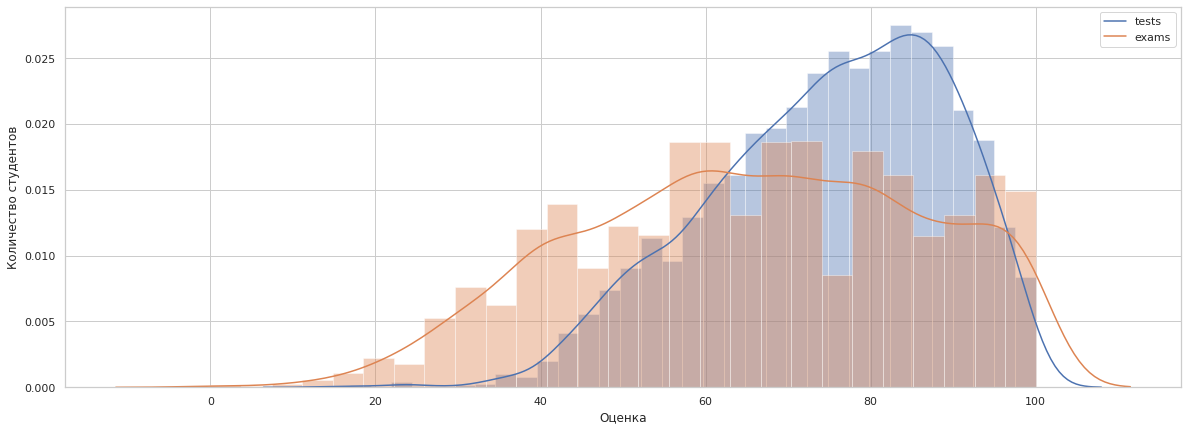

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

stat = tests.merge(students, how='inner', on='id_assessment')
cd = tests.merge(students, how='inner', on='id_assessment')\
          .query('code_module=="CCC" or code_module=="DDD"')
H1 = stat.query('assessment_type!="Exam" and (code_module=="CCC" or code_module=="DDD")')\
         .groupby('id_student', as_index=False)\
         .agg({'score': 'mean'})
H2 = stat.query('assessment_type=="Exam" and (code_module=="CCC" or code_module=="DDD")')\
         .groupby('id_student', as_index=False).agg({'score': 'max'})
H = H1.merge(H2, how='inner', on='id_student')\
      .rename(columns={'score_x': 'tests', 'score_y': 'exams'})
H.query("tests>=40 and exams<40")
ax = sns.distplot(H['tests'])
ax = sns.distplot(H['exams'])
ax.set_xlabel('Оценка')
ax.set_ylabel('Количество студентов')
plt.legend(labels=['tests', 'exams'])

В таблице сравнения результатов тестов и экзаменов получилось 4630 студентов. Из них 507 студентов имеют оценку по экзамену ниже 40 баллов, имея среднюю оценку по тестам выше 40 баллов. Это 11% студентов данной выборки.Из графика мы также видим значительное различие в распределении и величине оценок за тесты и за экзамены (экзамены блекло-оранжевые, тесты - синие) 
Среднее по тестам на 9,26 больше, чем среднее по экзаменам.В этом случае высока вероятность, что студенты, которые не сдали/могли бы не сдать экзамен будут посчитаны как сдавшие.
Все эти показатели привели меня к тому, что я отказываюсь от гипотезы, что оценки за тесты связаны с оценками за экзамены и можно надежно заменить одни другими при RFM-анализе.

In [76]:
import scipy
from scipy import stats
import scipy.stats as st

In [82]:
message_tests =  """В выборке с результатами тестов {num} значений, среднее равняется {mean},
                    стандартное отклонение {std}, стандартная ошибка выборки {sem}. 
                    Доверительный интервал среднего равняется {inter}"""
message_exams =  """В выборке с результатами экзаменов среднее равняется {mean}, 
                    стандартное отклонение {std}, стандартная ошибка выборки {sem}. 
                    Доверительный интервал среднего равняется {inter}"""

a = H.tests.mean().round(2)
b = H.tests.std().round(2)
c = H.tests.sem().round(2)
d = H.shape[0]
e = st.t.interval(alpha=0.99, df=len(H)-1, loc=H.tests.mean(), scale=H.tests.sem())

message_1 = message_tests.format(mean=a, std=b, sem=c, num=d, inter=e)
print(message_1)

f = H.exams.mean().round(2)
g = H.exams.std().round(2)
k = H.exams.sem().round(2)
l = st.t.interval(alpha=0.99, df=len(H)-1, loc=H.exams.mean(), scale=H.exams.sem()) 

message_2 = message_exams.format(mean=f, std=g, sem=k, inter=l)
print(message_2)

В выборке с результатами тестов 4630 значений, среднее равняется 74.86,
                    стандартное отклонение 14.32, стандартная ошибка выборки 0.21. 
                    Доверительный интервал среднего равняется (74.32036995141839, 75.40499021530648)
В выборке с результатами экзаменов среднее равняется 65.6, 
                    стандартное отклонение 20.66, стандартная ошибка выборки 0.3. 
                    Доверительный интервал среднего равняется (64.82054484240247, 66.38507070835347)


Далее проверю вторую гипотезу: выборка по предметам DDD и CCC является репрезентативной и ее результаты можно распространить на всю совокупность.
Отберу данные только по тестам. Генеральная совокупность в таблице stat, выборка (предметы ССС и DDD)  в таблице cd.
Построила графики и вижу, что распределение близко к нормальному, но имеются значительные выбросы на значениях кратных 20. Это говорит о вероятном вмешательстве человека в распределение оценок по тестам. 

Оценивая статистические показатели по обоим вариантам я выбираю второй, так как среднее в выборке ниже среднего по общей совокупности (на 5,48) и таким образом студенты, не сдавшие экзамен не будут учтены как сдавшие. И в целом показатели более сопоставимые, чем в первом варианте.
Таким образом я исследую выборку по предметам ССС и DDD. И следовательно ставлю задачу RFM-анализа выявить структуру студентов по группам, а также сформировать список лучших студентов с модулей CCC и DDD.

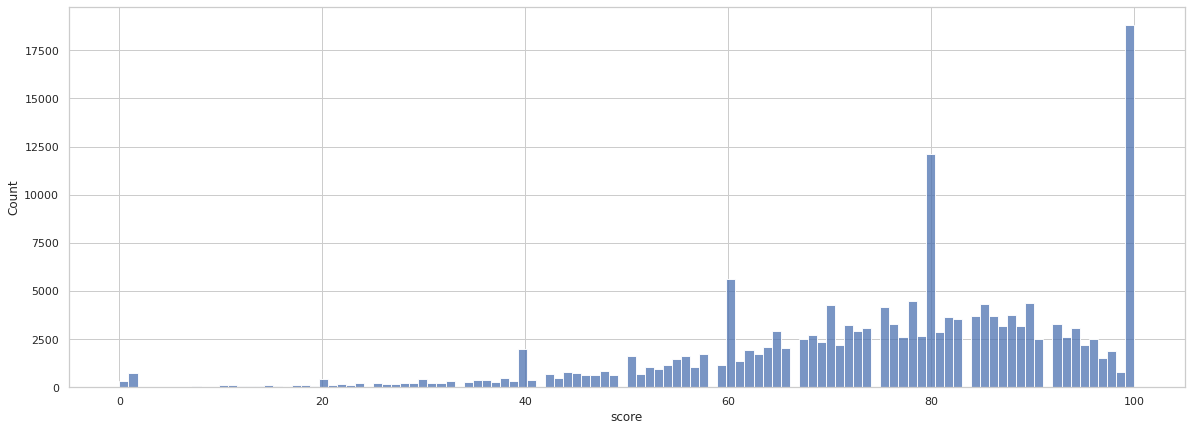

In [83]:
sns.histplot(data=stat, x="score")

In [84]:
message_stat =  """В выборке по всем предметам {num} значений, среднее равняется {mean}, 
                   стандартное отклонение {std}, стандартная ошибка выборки {sem}. 
                   Доверительный интервал среднего равняется {inter}"""
message_cd =  """В выборке по предметам CD {num} значений, среднее равняется {mean}, 
                 стандартное отклонение {std}, стандартная ошибка выборки {sem}. 
                 Доверительный интервал среднего равняется {inter}"""

a = stat.score.mean().round(2)
b = stat.score.std().round(2)
c = stat.score.sem().round(2)
d = len(stat)
e = st.t.interval(alpha=0.99, df=len(stat)-1, loc=stat.score.mean(), scale=stat.score.sem())
                  
message_3 = message_stat.format(mean=a, std=b, sem=c, num=d, inter=e)
print(message_3)

f = cd.score.mean().round(2)
g = cd.score.std().round(2)
k = cd.score.sem().round(2)
m = len(cd)
l = st.t.interval(alpha=0.99, df=len(cd)-1, loc=cd.score.mean(), scale=cd.score.sem()) 
message_4 = message_cd.format(mean=f, std=g, sem=k, inter=l, num=m)
print(message_4)

В выборке по всем предметам 173912 значений, среднее равняется 75.8, 
                   стандартное отклонение 18.8, стандартная ошибка выборки 0.05. 
                   Доверительный интервал среднего равняется (75.68340470926435, 75.91574113594024)
В выборке по предметам CD 49804 значений, среднее равняется 71.3, 
                 стандартное отклонение 21.11, стандартная ошибка выборки 0.09. 
                 Доверительный интервал среднего равняется (71.05346114011441, 71.5411432342825)


Далее провожу непосредственно RFM-анализ. 
В качестве показетеля Monetary я выберу среднее количество баллов, получаемых за экзамен.Рассчитаю показатель M (среднее количество баллов, получаемое за экзамен).
Для расчета M выберу максимальный балл, полученный при сдаче экзамена для каждого студента. Добавила условие, убирающее перезачет, но можно обойтись и без него, так как по экзаменам перезачетов нет (проверила).

In [85]:
M = students.merge(exams, how='inner', on='id_assessment').query('is_banked==0')
scores = M.groupby('id_student', as_index=False).agg({'score': 'max'})

Далее по показателю M я нахожу квинтили. И каждому значению присваиваю оценку в соответствии с его принадлежностью к определенному квинтилю. Так как по показателю M чем больше значение, тем лучше, то первому квинтилю(0-20%, 0-47 баллов) присваивается оценка один, второму (21-40%, 48-60 баллов) - два, третьему (41-60%, 61-73 балла) - три, четвертому (61-80%, 74-86 баллов) - четыре, пятому (81-100%, 87-100 баллов) - пять. То есть минимальное значение в ряду получит оценку 1, а максимальное - оценку 5.

In [86]:
quintilesM = scores['score'].quantile([.2, .4, .6, .8]).to_dict()


def m_score(x):
    if x <= quintilesM[.2]:
        return 1
    elif x <= quintilesM[.4]:
        return 2
    elif x <= quintilesM[.6]:
        return 3
    elif x <= quintilesM[.8]:
        return 4
    else:
        return 5

scores['M'] = scores['score'].apply(lambda x: m_score(x))

В качестве R-оценки я возьму количество дней просрочки сдачи зачетов. Это более общий показатель, который показывает не только внешнюю дисциплину (как человек ведет себя, когда его контролируют), но и внутреннюю (насколько он может выполнять в срок задачи, если нет непосредственного контроля). Для ранжирования по данному критерию я вычисляю опоздания по срокам сдачи тестов/экзаменов для каждого студента и суммирую дни опозданий. Далее аналогично показателю M вычисляю квинтили и оцениваю значения. По показателю R чем меньше значение, тем лучше, поэтому первому квинтилю(0-20%, без опозданий) присваивается оценка 5, второму (21-40%, общие опоздания до 1 дня) - четыре, третьему (41-60%, общие опоздания 2-8 дней ) - три, четвертому (61-80%, общие опоздания 9-18 дней), пятому (81-100%, общие опоздания свыше 19 дней) - один. То есть минимальное значение в ряду получит оценку 5, а максимальное - оценку 1.

In [87]:
passing = tests.merge(students, how='right', on='id_assessment').query('is_banked==0')
passing = passing.assign(delay=passing.date_submitted - passing.date)
passing['delay'] = passing['delay'].apply(lambda x: max(x, 0))
passing = passing.groupby('id_student', as_index=False).agg({'delay': 'sum'}) 
quintilesR = passing['delay'].quantile([.2, .4, .6, .8]).to_dict()


def r_score(x):
    if x <= quintilesR[.2]:
        return 5
    elif x <= quintilesR[.4]:
        return 4
    elif x <= quintilesR[.6]:
        return 3
    elif x <= quintilesR[.8]:
        return 2
    else:
        return 1


passing['R'] = passing['delay'].apply(lambda x: r_score(x))

Показатель F учитывает повторяемость. За показатель F я возьму количество регистраций на различные курсы одним и тем же студентом. Это показывает определенный уровень настойчивости в овладении знаниями (при повторной регистрации на один и тот же курс), либо в целом стремление к развитию (при регистрации на разные курсы). Так как количество уникальных значений равняется четырем, то считать квинтили и делать пятибалльную систему оценок считаю нецелесообразным. Я исключаю все значения ноль (количество отмены регистрации равно количеству регистраций), остается три значения, которым я и даю соответсвующие оценки. Если количество регистраций на одну больше, чем отмен (студент обучался до конца на одном курсе), то оценка 1, если на два больше (студент обучался до конца на двух курсах), то оценка два, если на три (студент обучался до конца на трех курсах), то три. Хотя оценка и соответсвует значению persist, все равно выношу ее в отдельный столбец.

In [89]:
registration = pd.read_csv(download_url_registration)
registration = registration.dropna(subset=['date_registration'])
repeat = registration.groupby('id_student', as_index=False)\
                     .agg({'date_registration': 'count', 'date_unregistration': 'count'})
repeat['persist'] = repeat.date_registration - repeat.date_unregistration
repeat=repeat.query('persist>0')


def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    else:
        return 3


repeat['F']= repeat['persist'].apply(lambda x: f_score(x))

Соединяю таблицы с показателями RFM и оценками и вывожу общую оценку в виде трехзначного числа, где число сотен - это оценка R, число десятков - это оценка F и число единиц - это оценка M. У меня получилось 47 различных групп из общего числа 4 632 отобранных студентов.

In [90]:
rfm = scores.merge(passing, how='inner', on='id_student')
rfm = rfm.merge(repeat, how='inner', on='id_student')
rfm['RFM_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.RFM_score.nunique()

47

Ранжирование произведено и можно уже отбирать конкретных студентов, которых можно рекомендовать работодателям. Я бы хотела отобрать студентов, которые наиболее успешно сдали экзамены (оценка 5), следовательно показатель M должен быть равен 5. Показатель сроков также считаю важным и отбираю тех, кто почти не задерживал сдачу зачетов и экзаменов (в сумме не более одного дня), показатель R должен быть больше 3. И показатель F наименее вариативен, поэтому он будет использоваться только для характеристики групп. Выбирая эти критерии мы получим: M=5,F>0,R>3 - две группы, всего 235 студентов. Это те студенты, которых я бы рекомендовала для помощи в трудоустройстве.

In [91]:
print(rfm.query('M==5 and F>0 and R>3').groupby('RFM_score', as_index=False).size())
rfm.query('RFM_score=="515" or RFM_score=="415"')

  RFM_score  size
0       415    10
1       515   225


,id_student,score,M,delay,R,date_registration,date_unregistration,persist,F,RFM_score
18,40184,100.0,5,0.0,5,1,0,1,1,515
29,50476,87.0,5,0.0,5,1,0,1,1,515
83,88490,96.0,5,0.0,5,1,0,1,1,515
115,117281,87.0,5,0.0,5,1,0,1,1,515
128,127580,91.0,5,0.0,5,1,0,1,1,515
...,...,...,...,...,...,...,...,...,...,...
4481,2516939,87.0,5,0.0,5,1,0,1,1,515
4518,2569416,91.0,5,0.0,5,1,0,1,1,515
4523,2581779,87.0,5,0.0,5,1,0,1,1,515
4535,2595730,89.0,5,0.0,5,2,1,1,1,515


Разбиваем всю совокупность студентов на группы по показателям R и M. R - показатель, характризующий дисциплину и ответственность студента, M - показатель, характиризующий уровень усвоения материала. Выделим семь групп и в зависимости от рангов по показателям и дадим им условные имена. Добавляем название сегментов в таблицу и строим график. На графике видно распределение студентов по группам и средний балл за экзамен.

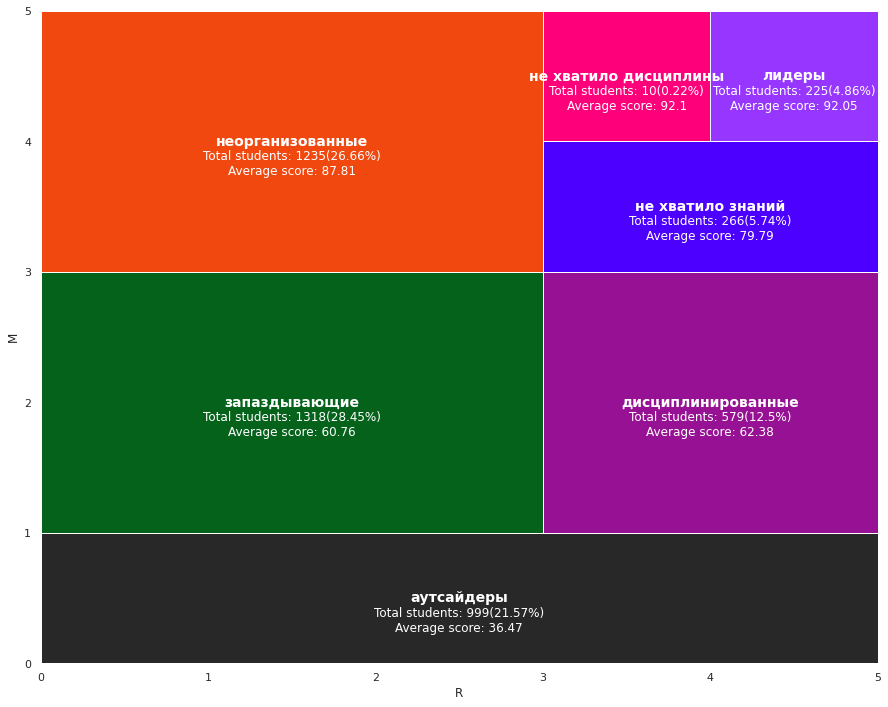

In [92]:
segt_map = {
    r'[1-3][2-3]': 'запаздывающие',
    r'[3-5][2-3]': 'дисциплинированные',
    r'[1-3][3-5]': 'неорганизованные',
    r'[3-5][3-4]': 'не хватило знаний',
    r'[3-4][4-5]': 'не хватило дисциплины',
    r'[4-5][4-5]': 'лидеры',
    r'[1-5][1]': 'аутсайдеры'
}
rfm['Segment'] = rfm['R'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm_coordinates = {"аутсайдеры": [0, 1, 0, 1],
                   "запаздывающие": [1, 3, 0, 0.6],
                   "дисциплинированные": [1,3, 0.6, 1],
                   "неорганизованные": [3, 5, 0, 0.6],
                   "не хватило знаний": [3, 4, 0.6, 1],
                   "не хватило дисциплины": [4, 5, 0.6, 0.8],
                   "лидеры": [4, 5, 0.8, 1],
                   }

fig, ax = plt.subplots(figsize=(15, 12))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"]="white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, facecolor=color)
    
    users = rfm[rfm.Segment==key].shape[0]
    users_percentage = (rfm[rfm.Segment==key].shape[0] / rfm.shape[0]) * 100
    avg_monetary = rfm[rfm.Segment==key]["score"].mean()
    
    user_txt = "\n\nTotal students: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage score: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x=x, y=y, s=key, ha="center", va="center", fontsize=14, color="white", fontweight="bold")
    plt.text(x=x, y=y, s=user_txt, ha="center", va="center", fontsize=12, color="white")    
    plt.text(x=x, y=y, s=monetary_txt, ha="center", va="center", fontsize=12, color="white")    
    
    ax.set_xlabel("R")
    ax.set_ylabel("M")
    
sns.despine(left = True, bottom = True)
plt.show()

Далее рассмотрим распределение показателей по оценкам. По оценке знаний студенты распределились примерно равномерно. По показателю дисциплины четверть студентов сдает задания без опозданий. По показателю F - активности студентов в обучении на нескольких курсах основную часть все-таки составляют студенты, которые обучались только на одном курсе. Можно также отметить, что студенты, обучавшиеся на нескольких курсах имеют склонность опоздывать со сроками сдачи тестов, а студенты, обучавшиеся только на одном курсе более дисциплинированы. Возможно первые узнали, что зачет по курсу определяется по сдаче экзамена и сдавать тесты необязательно вовремя или вообще необязательно.

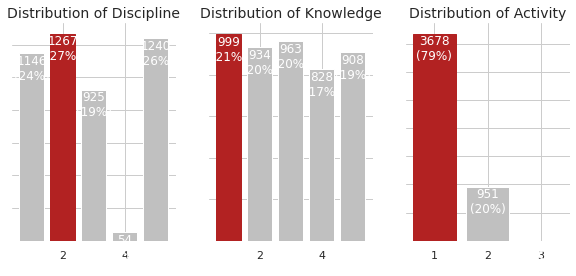

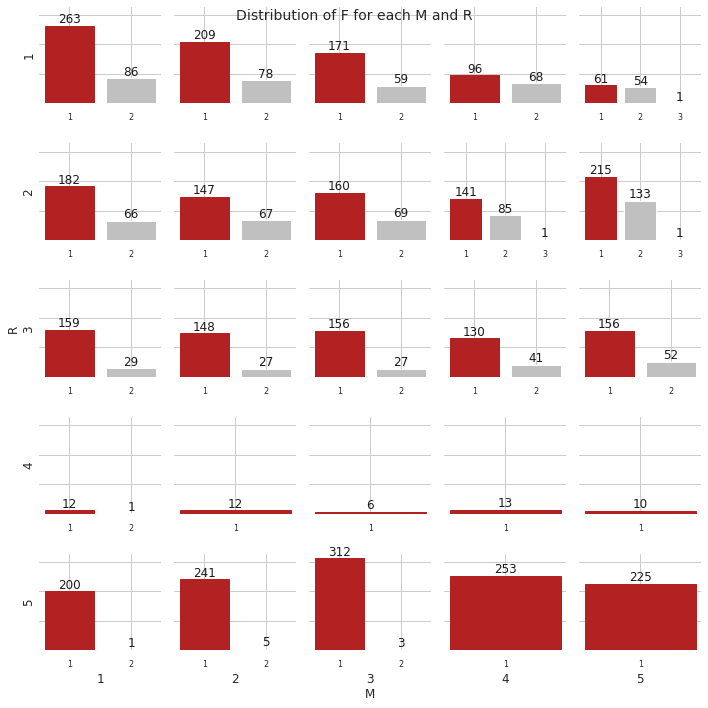

In [93]:
# график распределения пользователей по группам R и M
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i, p in enumerate(['R', 'M','F']):
    parameters = {'R': 'Discipline', 'M': 'Knowledge','F': 'Activity'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# график распределения по группам F для RM
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
m_range = range(1, 6)
for r in r_range:
    for m in m_range:
        y = rfm[(rfm['R'] == r) & (rfm['M'] == m)]['F'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, m - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if m == 3:
                ax.set_xlabel('{}\nM'.format(m), va='top')
            else:
                ax.set_xlabel('{}\n'.format(m), va='top')
        if m == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of F for each M and R',
             fontsize=14)
plt.tight_layout()
plt.show()

## Выводы и рекомендации <a name="paragraph8"></a>

В проекте проделана следующая работа:

- Выполнены задачи, поставленные менеджером Василием и посчитаны необходимые ему показатели.
- Проведен RFM-анализ, который делит студентов на группы и сформирован список "лидеров"(по предметам ССС и DDD), которых можно рекомендовать работодателям.


По итогам проекта можно дать следующие рекомендации:
- Провести мероприятия по усовершенствованию сбора данных, так как часть данных почему-то не попала в таблицы (оценки за экзамены), часть ячеек была не заполнена.
- Выявлено, что основной причиной незавершения курса является отмена регистрации, а не несдача экзамена или проблемы при обучении. В среднем отток составляет 30%. Рекомендовала бы принять решение нужны ли такие студенты платформе (приносят ли они прибыль или наоборот наносят репутационный вред). Если прибыли не приносят, то можно разработать ряд мероприятий, позволяющий студентам предварительно оценить насколько они готовы к прохождению курса: разместить демонстрационный доступ, тест, более полную программу курса с ссылками на дополнительные материалы.
- Я считаю, что отток студентов слишком велик. Я бы рекомендовала провести опрос среди студентов, которые отменили регистрацию и выяснить причины отмены, чтобы повлиять на них и в будущем снизить количество отмен регистраций.
- Данные по сдаче экзаменов выглядят так, как будто в них искусственно вмешались (выбросы на значениях, кратных 20). Я бы рекомендовала проверить механизм сдачи экзаменов и попытаться выяснить почему так велико число студентов, сдавших его на 100%.